# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [29]:
#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'is_promoted'
VarId = 'employee_id'
VarDate = 'reference_date' 

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

# ATENÇÃO: nome do bucket criado no S3 (altere para o bucket com o seu nome)
bucket = 'aula-deploy-modelos3'

CAT = ['department','education','region']

#float
NUM = ['age','no_of_trainings','previous_year_rating','length_of_service','avg_training_score']
selected_features = CAT + NUM

# 2. Import Libraries

In [34]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

In [35]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [36]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='us-east-1')

In [37]:
query4="select * from auladeploymodelos.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="auladeploymodelos", boto3_session=my_boto3_session)

In [38]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [39]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

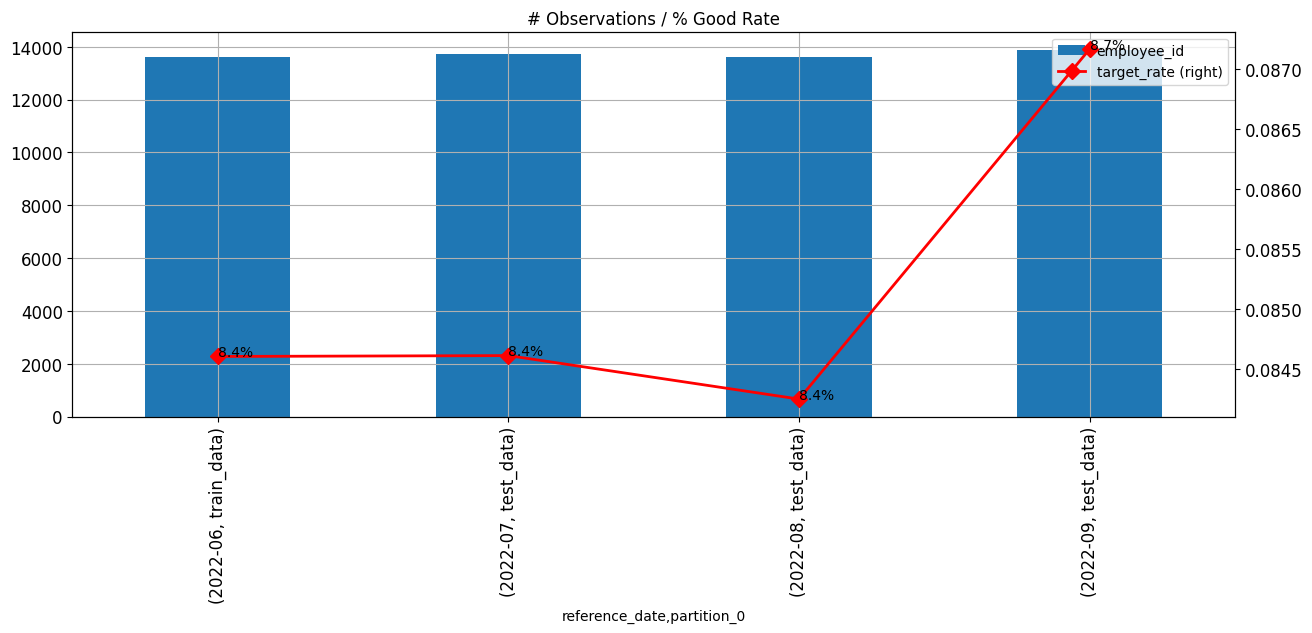

In [40]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'partition_0']].groupby(by=[VarDate, 'partition_0']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [41]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [42]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [43]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with SageMaker Autopilot

### 4.1.1 SageMaker Setup

In [44]:
# region = my_boto3_session.region_name
# session = sagemaker.Session(my_boto3_session)

# # You can modify the following to use a bucket of your choosing
# prefix = "models/%s/sagemaker-temp" % ModelName

# role = get_execution_role()

# # # This is the client we will use to interact with SageMaker AutoPilot
# sm = my_boto3_session.client(service_name="sagemaker", region_name=region)

# input_data_config = [
#     {
#         "DataSource": {
#             "S3DataSource": {
#                 "S3DataType": "S3Prefix",
#                 "S3Uri": 's3://%s/databases/%s/train_data/train_data.csv' % (bucket, ModelName),
#             }
#         },
#         "TargetAttributeName": 'Survived',
#     }
# ]

# output_data_config = {"S3OutputPath": "s3://%s/%s" % (bucket, prefix)}

### 4.1.2 SageMaker Setup and Run Auto Pilot

In [45]:
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())

# auto_ml_job_name = "autopilot-" + ModelName.replace('_', '-')[0:10] + '-' + timestamp_suffix
# print("AutoMLJobName: " + auto_ml_job_name)

# #Run SageMaker Autopilot
# sm.create_auto_ml_job(
#     AutoMLJobName=auto_ml_job_name,
#     InputDataConfig=input_data_config,
#     OutputDataConfig=output_data_config,
#     AutoMLJobConfig={"CompletionCriteria": {"MaxCandidates": 3}},
#     RoleArn=role
# )

In [46]:
# print("JobStatus - Secondary Status")
# print("------------------------------")

# describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
# print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime()))
# job_run_status = describe_response["AutoMLJobStatus"]

# while job_run_status not in ("Failed", "Completed", "Stopped"):
#     describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
#     job_run_status = describe_response["AutoMLJobStatus"]

#     print(
#         describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime())
#     )
#     sleep(30)

### 4.1.3 Create SageMaker Endpoint and Predictor with the Best Candidate

In [47]:
# #Select best candidate
# best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
# best_candidate_name = best_candidate["CandidateName"]

# #Add probability and probabilities to the SAGEMAKER_INFERENCE_OUTPUT
# for i in range(len(best_candidate["InferenceContainers"])):
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_INPUT']='predicted_label, probability, probabilities'
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_OUTPUT']='predicted_label, probability, probabilities'

# #Create endpoint configuration
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
# model_name = best_candidate_name + timestamp_suffix + "-model"
# model_arn = sm.create_model(
#     Containers=best_candidate["InferenceContainers"], ModelName=model_name, ExecutionRoleArn=role
# )

# epc_name = best_candidate_name + timestamp_suffix + "-epc"
# ep_config = sm.create_endpoint_config(
#     EndpointConfigName=epc_name,
#     ProductionVariants=[
#         {
#             "InstanceType": "ml.m5.2xlarge",
#             "InitialInstanceCount": 1,
#             "ModelName": model_name,
#             "VariantName": "main",
#         }
#     ],
# )

# #Create end endpoint
# ep_name = best_candidate_name + timestamp_suffix + "-ep"
# create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
# sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
# print("ep_name: " + str(ep_name))

In [48]:
# #Create Predictor
# sm_predictor = Predictor(
#     endpoint_name=ep_name,
#     sagemaker_session=session,
#     serializer=CSVSerializer(),
#     deserializer=CSVDeserializer(),
# )

## 4.2 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [49]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,23 mins 07 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,3 months and 27 days !!!
H2O_cluster_name:,H2O_from_python_unknownUser_rccd6y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.531 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [50]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 12242
Validation: 1362


In [51]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 41204


## 4.2.2 Train the H2O Champion algorithm with new data

In [52]:
# h2o_champion = h2o.load_model('StackedEnsemble_BestOfFamily_3_AutoML_1_20220713_190002')
# h2o_champion

In [53]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:09.418705

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_hr_analytics_v1_20221104_234228


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,88.0,88.0,20401.0,4.0,4.0,4.0,8.0,16.0,12.5




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.05387545056976346
RMSE: 0.23211085836247183
LogLoss: 0.19836952957521004
Mean Per-Class Error: 0.27846020302250396
AUC: 0.8720428393171307
AUCPR: 0.5868947632099697
Gini: 0.7440856786342613

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21375054242741376: 


,,0,1,Error,Rate
0,0,10892.0,301.0,0.0269,(301.0/11193.0)
1,1,556.0,493.0,0.53,(556.0/1049.0)
2,Total,11448.0,794.0,0.07,(857.0/12242.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.213751,0.534997,165.0
1,max f2,0.110287,0.553756,236.0
2,max f0point5,0.339853,0.679866,120.0
3,max accuracy,0.307331,0.940614,128.0
4,max precision,0.996365,1.000000,0.0
5,max recall,0.009631,1.000000,389.0
6,max specificity,0.996365,1.000000,0.0
7,max absolute_mcc,0.283577,0.538787,135.0
8,max min_per_class_accuracy,0.088892,0.775024,260.0
9,max mean_per_class_accuracy,0.091548,0.776890,257.0



Gains/Lift Table: Avg response rate:  8.57 %, avg score:  8.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010047,0.843199,11.575283,11.575283,0.991870,0.940729,0.991870,0.940729,0.116301,0.116301,1057.528269,1057.528269,0.116212
1,2,0.020013,0.500598,11.000563,11.289096,0.942623,0.668703,0.967347,0.805272,0.109628,0.225929,1000.056260,1028.909554,0.225215
2,3,0.030060,0.373407,9.393057,10.655365,0.804878,0.420965,0.913043,0.676821,0.094376,0.320305,839.305727,965.536536,0.317446
3,4,0.040026,0.281840,6.504680,9.621930,0.557377,0.323262,0.824490,0.588792,0.064824,0.385129,550.468049,862.192953,0.377445
4,5,0.050074,0.245784,2.846381,8.262399,0.243902,0.262491,0.707993,0.523319,0.028599,0.413727,184.638099,726.239859,0.397735
5,6,0.100065,0.159736,2.669645,5.468305,0.228758,0.195341,0.468571,0.359464,0.133460,0.547188,166.964492,446.830451,0.489026
6,7,0.150139,0.126717,1.656287,4.196941,0.141925,0.141288,0.359630,0.286699,0.082936,0.630124,65.628727,319.694076,0.524969
7,8,0.200049,0.105718,1.337007,3.483417,0.114566,0.114953,0.298489,0.243850,0.066730,0.696854,33.700711,248.341709,0.543365
8,9,0.300033,0.082730,1.010651,2.659386,0.086601,0.092918,0.227879,0.193553,0.101049,0.797903,1.065129,165.938624,0.544530
9,10,0.400016,0.067057,0.791359,2.192475,0.067810,0.074568,0.187870,0.163813,0.079123,0.877026,-20.864097,119.247480,0.521714




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.05227570654046885
RMSE: 0.2286388124104673
LogLoss: 0.1989006003162308
Mean Per-Class Error: 0.32072829131652664
AUC: 0.8258442265795206
AUCPR: 0.473000023814308
Gini: 0.6516884531590412

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24073048693475108: 


,,0,1,Error,Rate
0,0,1230.0,30.0,0.0238,(30.0/1260.0)
1,1,63.0,39.0,0.6176,(63.0/102.0)
2,Total,1293.0,69.0,0.0683,(93.0/1362.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.240730,0.456140,64.0
1,max f2,0.075746,0.487945,223.0
2,max f0point5,0.378220,0.578512,33.0
3,max accuracy,0.459508,0.940529,23.0
4,max precision,0.980346,1.000000,0.0
5,max recall,0.012911,1.000000,375.0
6,max specificity,0.980346,1.000000,0.0
7,max absolute_mcc,0.378220,0.447398,33.0
8,max min_per_class_accuracy,0.083925,0.748413,206.0
9,max mean_per_class_accuracy,0.075746,0.766667,223.0



Gains/Lift Table: Avg response rate:  7.49 %, avg score:  8.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010279,0.699552,13.352941,13.352941,1.000000,0.895409,1.000000,0.895409,0.137255,0.137255,1235.294118,1235.294118,0.137255
1,2,0.020558,0.418699,9.537815,11.445378,0.714286,0.549744,0.857143,0.722576,0.098039,0.235294,853.781513,1044.537815,0.232120
2,3,0.030103,0.315866,6.162896,9.770445,0.461538,0.368806,0.731707,0.610405,0.058824,0.294118,516.289593,877.044476,0.285387
3,4,0.040382,0.265071,3.815126,8.254545,0.285714,0.280184,0.618182,0.526349,0.039216,0.333333,281.512605,725.454545,0.316667
4,5,0.050661,0.240632,4.768908,7.547315,0.357143,0.251561,0.565217,0.470595,0.049020,0.382353,376.890756,654.731458,0.358543
5,6,0.100587,0.158918,1.963668,4.775869,0.147059,0.194290,0.357664,0.333451,0.098039,0.480392,96.366782,377.586947,0.410551
6,7,0.150514,0.121786,1.178201,3.582496,0.088235,0.137958,0.268293,0.268604,0.058824,0.539216,17.820069,258.249641,0.420168
7,8,0.200441,0.102600,1.963668,3.179272,0.147059,0.110784,0.238095,0.229294,0.098039,0.637255,96.366782,217.927171,0.472176
8,9,0.300294,0.080809,1.276384,2.546527,0.095588,0.090733,0.190709,0.183220,0.127451,0.764706,27.638408,154.652668,0.502007
9,10,0.400147,0.067956,0.883651,2.131570,0.066176,0.074122,0.159633,0.155996,0.088235,0.852941,-11.634948,113.157043,0.489449




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.06027662513047764
RMSE: 0.24551298362913038
LogLoss: 0.22639607168967507
Mean Per-Class Error: 0.33138246812129024
AUC: 0.7934771638647572
AUCPR: 0.4679898575808174
Gini: 0.5869543277295144

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22412133727467154: 


,,0,1,Error,Rate
0,0,10881.0,312.0,0.0279,(312.0/11193.0)
1,1,666.0,383.0,0.6349,(666.0/1049.0)
2,Total,11547.0,695.0,0.0799,(978.0/12242.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.224121,0.439220,165.0
1,max f2,0.118216,0.463450,237.0
2,max f0point5,0.371675,0.581646,112.0
3,max accuracy,0.371675,0.932446,112.0
4,max precision,0.998033,1.000000,0.0
5,max recall,0.001746,1.000000,399.0
6,max specificity,0.998033,1.000000,0.0
7,max absolute_mcc,0.371675,0.445377,112.0
8,max min_per_class_accuracy,0.079809,0.707853,280.0
9,max mean_per_class_accuracy,0.118216,0.710356,237.0



Gains/Lift Table: Avg response rate:  8.57 %, avg score:  8.52 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010047,0.708270,11.480403,11.480403,0.983740,0.873033,0.983740,0.873033,0.115348,0.115348,1048.040333,1048.040333,0.115169
1,2,0.020013,0.461268,9.661364,10.574596,0.827869,0.575788,0.906122,0.725017,0.096282,0.211630,866.136367,957.459582,0.209575
2,3,0.030060,0.329124,6.451797,9.196595,0.552846,0.384111,0.788043,0.611073,0.064824,0.276454,545.179691,819.659510,0.269485
3,4,0.040026,0.273660,3.539311,7.788047,0.303279,0.297655,0.667347,0.533038,0.035272,0.311725,253.931144,678.804693,0.297163
4,5,0.050074,0.244399,2.656622,6.758414,0.227642,0.257995,0.579119,0.477850,0.026692,0.338418,165.662226,575.841359,0.315367
5,6,0.100065,0.159487,2.459887,4.610905,0.210784,0.191739,0.395102,0.334911,0.122974,0.461392,145.988710,361.090485,0.395190
6,7,0.150057,0.128363,1.353891,3.525825,0.116013,0.142288,0.302123,0.270739,0.067684,0.529075,35.389135,252.582468,0.414539
7,8,0.200049,0.106447,1.029720,2.902053,0.088235,0.116395,0.248673,0.232169,0.051478,0.580553,2.972018,190.205337,0.416164
8,9,0.300033,0.083630,0.934376,2.246339,0.080065,0.093628,0.192486,0.186001,0.093422,0.673975,-6.562428,124.633939,0.408988
9,10,0.400016,0.069071,0.943910,1.920799,0.080882,0.076202,0.164591,0.158557,0.094376,0.768351,-5.608983,92.079857,0.402855




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.919458,0.007858,0.917926,0.914659,0.924837,0.929739,0.910131
1,auc,0.798745,0.008348,0.805346,0.794245,0.792972,0.809933,0.791229
2,err,0.080542,0.007858,0.082074,0.085341,0.075163,0.070261,0.089869
3,err_count,197.200000,19.253570,201.000000,209.000000,184.000000,172.000000,220.000000
4,f0point5,0.502157,0.048146,0.514950,0.435356,0.550062,0.539359,0.471056
5,f1,0.450396,0.042390,0.480620,0.387097,0.491713,0.462500,0.430052
6,f2,0.408807,0.041394,0.450581,0.348469,0.444555,0.404814,0.395615
7,lift_top_group,11.307500,0.661340,10.935070,10.668911,11.492958,12.363636,11.076923
8,logloss,0.226396,0.010603,0.221155,0.235736,0.225797,0.211828,0.237462
9,max_per_class_error,0.614713,0.041686,0.567442,0.673267,0.582160,0.626263,0.624434



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-11-04 23:42:35,7.429 sec,0.0,0.279904,0.292448,0.500000,0.085689,1.000000,0.914311,0.263435,0.266882,0.500000,0.074890,1.000000,0.925110
1,,2022-11-04 23:42:35,7.498 sec,5.0,0.274100,0.275540,0.763927,0.306648,7.874987,0.126368,0.258822,0.254103,0.734189,0.243523,5.722689,0.095448
2,,2022-11-04 23:42:35,7.579 sec,10.0,0.266703,0.261226,0.780233,0.374931,10.070220,0.109051,0.252324,0.242033,0.747304,0.327821,10.491597,0.079295
3,,2022-11-04 23:42:35,7.662 sec,15.0,0.258128,0.245959,0.815315,0.448611,11.385524,0.097288,0.245036,0.229292,0.791523,0.398690,13.352941,0.127019
4,,2022-11-04 23:42:35,7.732 sec,20.0,0.256466,0.241747,0.821560,0.450950,11.385524,0.095001,0.244193,0.226623,0.796475,0.387238,12.399160,0.080764
5,,2022-11-04 23:42:35,7.795 sec,25.0,0.253330,0.235843,0.825133,0.453949,11.385524,0.097942,0.241518,0.221556,0.802077,0.390637,12.399160,0.110132
6,,2022-11-04 23:42:35,7.861 sec,30.0,0.250449,0.229965,0.835866,0.478376,11.290645,0.095981,0.239118,0.217006,0.806404,0.408486,12.399160,0.108664
7,,2022-11-04 23:42:35,7.929 sec,35.0,0.248480,0.226335,0.837768,0.483817,11.290645,0.098187,0.237749,0.214436,0.808411,0.409049,12.399160,0.101322
8,,2022-11-04 23:42:36,7.992 sec,40.0,0.247672,0.224395,0.840875,0.486996,11.290645,0.091325,0.237148,0.212869,0.811815,0.412426,12.399160,0.101322
9,,2022-11-04 23:42:36,8.072 sec,45.0,0.246835,0.222372,0.843627,0.490938,11.290645,0.091897,0.236624,0.211734,0.810010,0.412996,12.399160,0.102056



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,avg_training_score,667.872314,1.000000,0.553866
1,department,228.480896,0.342103,0.189479
2,region,133.841568,0.200400,0.110995
3,previous_year_rating,115.603645,0.173092,0.095870
4,age,25.013201,0.037452,0.020743
5,length_of_service,13.748620,0.020586,0.011402
6,no_of_trainings,10.673480,0.015981,0.008852
7,education,10.604393,0.015878,0.008794


## 4.2.3 Using H2O AutoML to performe all algorithms

In [54]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*25

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
23:43:22.208: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:25:04.216510



In [55]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_1_20221104_234322,0.526045,0.804326,0.208736,0.323082,0.232129,0.053884
StackedEnsemble_AllModels_2_AutoML_1_20221104_234322,0.521263,0.802297,0.209878,0.3219,0.232864,0.0542257
GBM_grid_1_AutoML_1_20221104_234322_model_2,0.521051,0.802367,0.210662,0.327248,0.233502,0.0545231
StackedEnsemble_BestOfFamily_2_AutoML_1_20221104_234322,0.520629,0.800536,0.210797,0.321988,0.233094,0.054333
StackedEnsemble_BestOfFamily_3_AutoML_1_20221104_234322,0.520253,0.801079,0.210132,0.324884,0.232888,0.0542369
StackedEnsemble_AllModels_1_AutoML_1_20221104_234322,0.519901,0.800317,0.210833,0.32016,0.233191,0.054378
XGBoost_grid_1_AutoML_1_20221104_234322_model_16,0.518277,0.802907,0.210853,0.326385,0.234199,0.0548492
XGBoost_grid_1_AutoML_1_20221104_234322_model_44,0.517556,0.800898,0.209831,0.325688,0.232863,0.0542252
StackedEnsemble_BestOfFamily_1_AutoML_1_20221104_234322,0.517246,0.799275,0.212801,0.326556,0.234275,0.0548849
GBM_grid_1_AutoML_1_20221104_234322_model_34,0.516814,0.802242,0.211948,0.325606,0.234662,0.0550664


In [56]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_4_AutoML_1_20221104_234322

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.048435191570272124
RMSE: 0.22007996630832194
LogLoss: 0.18453389127831077
Null degrees of freedom: 10052
Residual degrees of freedom: 10049
Null deviance: 5849.519146338075
Residual deviance: 3710.238418041718
AIC: 3718.238418041718
AUC: 0.8655134157056772
AUCPR: 0.6065370505663542
Gini: 0.7310268314113544

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2917745967850125: 


,,0,1,Error,Rate
0,0,9117.0,81.0,0.0088,(81.0/9198.0)
1,1,490.0,365.0,0.5731,(490.0/855.0)
2,Total,9607.0,446.0,0.0568,(571.0/10053.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.291775,0.561107,129.0
1,max f2,0.110927,0.546367,229.0
2,max f0point5,0.401292,0.724247,101.0
3,max accuracy,0.375007,0.945190,107.0
4,max precision,0.999122,1.000000,0.0
5,max recall,0.005661,1.000000,392.0
6,max specificity,0.999122,1.000000,0.0
7,max absolute_mcc,0.375007,0.578467,107.0
8,max min_per_class_accuracy,0.077223,0.767558,269.0
9,max mean_per_class_accuracy,0.079495,0.769795,266.0



Gains/Lift Table: Avg response rate:  8.50 %, avg score:  8.63 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010047,0.977209,11.757895,11.757895,1.000000,0.994302,1.000000,0.994302,0.118129,0.118129,1075.789474,1075.789474,0.118129
1,2,0.020094,0.859907,11.757895,11.757895,1.000000,0.921675,1.000000,0.957989,0.118129,0.236257,1075.789474,1075.789474,0.236257
2,3,0.030041,0.551929,11.052421,11.524294,0.940000,0.752644,0.980132,0.889994,0.109942,0.346199,1005.242105,1052.429418,0.345547
3,4,0.040088,0.331200,5.820740,10.094867,0.495050,0.400362,0.858561,0.767282,0.058480,0.404678,482.073997,909.486744,0.398481
4,5,0.050035,0.258889,3.527368,8.789202,0.300000,0.288805,0.747515,0.672157,0.035088,0.439766,252.736842,778.920163,0.425959
5,6,0.100070,0.157121,2.267427,5.528314,0.192843,0.196289,0.470179,0.434223,0.113450,0.553216,126.742702,452.831432,0.495269
6,7,0.150005,0.117783,1.452170,4.171402,0.123506,0.133449,0.354775,0.334098,0.072515,0.625731,45.217027,317.140165,0.519947
7,8,0.200040,0.097845,1.309030,3.455453,0.111332,0.106842,0.293884,0.277256,0.065497,0.691228,30.903003,245.545290,0.536847
8,9,0.300010,0.072045,0.971050,2.627593,0.082587,0.084080,0.223475,0.212885,0.097076,0.788304,-2.894999,162.759319,0.533684
9,10,0.399980,0.055767,0.690264,2.143381,0.058706,0.063461,0.182293,0.175539,0.069006,0.857310,-30.973553,114.338146,0.499841




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.04871384659394288
RMSE: 0.22071213513067847
LogLoss: 0.1882254938716968
Null degrees of freedom: 1361
Residual degrees of freedom: 1358
Null deviance: 726.9870883298025
Residual deviance: 512.726245306502
AIC: 520.726245306502
AUC: 0.8289565826330533
AUCPR: 0.5092455677182949
Gini: 0.6579131652661065

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2676000830403196: 


,,0,1,Error,Rate
0,0,1240.0,20.0,0.0159,(20.0/1260.0)
1,1,63.0,39.0,0.6176,(63.0/102.0)
2,Total,1303.0,59.0,0.0609,(83.0/1362.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.267600,0.484472,52.0
1,max f2,0.126424,0.500000,131.0
2,max f0point5,0.638038,0.653153,27.0
3,max accuracy,0.638038,0.945668,27.0
4,max precision,0.999044,1.000000,0.0
5,max recall,0.010249,1.000000,373.0
6,max specificity,0.999044,1.000000,0.0
7,max absolute_mcc,0.444776,0.508736,31.0
8,max min_per_class_accuracy,0.073046,0.746032,214.0
9,max mean_per_class_accuracy,0.082192,0.759967,196.0



Gains/Lift Table: Avg response rate:  7.49 %, avg score:  8.08 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010279,0.936479,13.352941,13.352941,1.000000,0.982283,1.000000,0.982283,0.137255,0.137255,1235.294118,1235.294118,0.137255
1,2,0.020558,0.724218,12.399160,12.876050,0.928571,0.845144,0.964286,0.913713,0.127451,0.264706,1139.915966,1187.605042,0.263912
2,3,0.030103,0.353107,6.162896,10.747489,0.461538,0.476023,0.804878,0.774933,0.058824,0.323529,516.289593,974.748924,0.317180
3,4,0.040382,0.292428,2.861345,8.740107,0.214286,0.320677,0.654545,0.659304,0.029412,0.352941,186.134454,774.010695,0.337862
4,5,0.050661,0.237440,2.861345,7.547315,0.214286,0.261967,0.565217,0.578685,0.029412,0.382353,186.134454,654.731458,0.358543
5,6,0.100587,0.149971,1.963668,4.775869,0.147059,0.184207,0.357664,0.382886,0.098039,0.480392,96.366782,377.586947,0.410551
6,7,0.150514,0.118529,2.160035,3.908178,0.161765,0.130615,0.292683,0.299206,0.107843,0.588235,116.003460,290.817791,0.473156
7,8,0.200441,0.095901,1.178201,3.228184,0.088235,0.106470,0.241758,0.251198,0.058824,0.647059,17.820069,222.818358,0.482773
8,9,0.300294,0.070571,1.178201,2.546527,0.088235,0.081890,0.190709,0.194900,0.117647,0.764706,17.820069,154.652668,0.502007
9,10,0.400147,0.056466,0.589100,2.058068,0.044118,0.063064,0.154128,0.162002,0.058824,0.823529,-41.089965,105.806800,0.457656




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0534970451809349
RMSE: 0.23129428263780083
LogLoss: 0.20743518669430683
Null degrees of freedom: 12241
Residual degrees of freedom: 12238
Null deviance: 7161.659479511147
Residual deviance: 5078.843111023409
AIC: 5086.843111023409
AUC: 0.8101208819314332
AUCPR: 0.5337036878782399
Gini: 0.6202417638628663

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30963133157847494: 


,,0,1,Error,Rate
0,0,11056.0,137.0,0.0122,(137.0/11193.0)
1,1,648.0,401.0,0.6177,(648.0/1049.0)
2,Total,11704.0,538.0,0.0641,(785.0/12242.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.309631,0.505356,140.0
1,max f2,0.132174,0.489027,224.0
2,max f0point5,0.511729,0.690262,97.0
3,max accuracy,0.511729,0.941186,97.0
4,max precision,0.999127,1.000000,0.0
5,max recall,0.001363,1.000000,399.0
6,max specificity,0.999127,1.000000,0.0
7,max absolute_mcc,0.511729,0.541726,97.0
8,max min_per_class_accuracy,0.067980,0.715920,290.0
9,max mean_per_class_accuracy,0.130989,0.724128,225.0



Gains/Lift Table: Avg response rate:  8.57 %, avg score:  8.56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010047,0.971472,11.575283,11.575283,0.991870,0.991435,0.991870,0.991435,0.116301,0.116301,1057.528269,1057.528269,0.116212
1,2,0.020013,0.808924,11.383191,11.479629,0.975410,0.896210,0.983673,0.944017,0.113441,0.229743,1038.319086,1047.962880,0.229385
2,3,0.030060,0.523773,9.962333,10.972489,0.853659,0.684584,0.940217,0.857304,0.100095,0.329838,896.233347,997.248933,0.327872
3,4,0.040026,0.334250,3.826283,9.193230,0.327869,0.402085,0.787755,0.743964,0.038132,0.367969,282.628264,819.322970,0.358678
4,5,0.050074,0.263810,2.561743,7.862605,0.219512,0.297476,0.673736,0.654375,0.025739,0.393708,156.174289,686.260511,0.375840
5,6,0.100065,0.158394,1.964096,4.915758,0.168301,0.200928,0.421224,0.427836,0.098189,0.491897,96.409590,391.575806,0.428554
6,7,0.150057,0.119614,1.258547,3.697351,0.107843,0.136298,0.316821,0.330710,0.062917,0.554814,25.854689,269.735129,0.442690
7,8,0.200049,0.097783,0.972514,3.016420,0.083333,0.107588,0.258473,0.274952,0.048618,0.603432,-2.748650,201.642000,0.441188
8,9,0.300033,0.071409,0.972514,2.335303,0.083333,0.083226,0.200109,0.211061,0.097235,0.700667,-2.748650,133.530333,0.438182
9,10,0.400016,0.055351,0.743687,1.937480,0.063725,0.062902,0.166020,0.174029,0.074357,0.775024,-25.631320,93.748045,0.410153




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.937976,0.005616,0.935872,0.943588,0.938628,0.929526,0.942266
1,auc,0.809844,0.026395,0.786021,0.850651,0.818943,0.804893,0.788710
2,err,0.062024,0.005616,0.064128,0.056412,0.061372,0.070474,0.057734
3,err_count,152.000000,16.140013,160.000000,139.000000,153.000000,174.000000,134.000000
4,f0point5,0.649069,0.061385,0.582192,0.714286,0.691244,0.585526,0.672098
5,f1,0.512687,0.039726,0.459459,0.561514,0.540540,0.505682,0.496241
6,f2,0.424831,0.036200,0.379464,0.462578,0.443787,0.445000,0.393325
7,lift_top_group,11.600246,0.467849,11.976000,11.460465,10.982379,11.430555,12.151833
8,logloss,0.207268,0.008777,0.209841,0.192672,0.211311,0.215747,0.206772
9,max_per_class_error,0.618397,0.036141,0.660000,0.586047,0.603524,0.587963,0.654450



See the whole table with table.as_data_frame()



## 4.3 Compare performance on the TEST dataset for all trained models

In [57]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(sm_predictor)
except NameError:
    pass
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [58]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


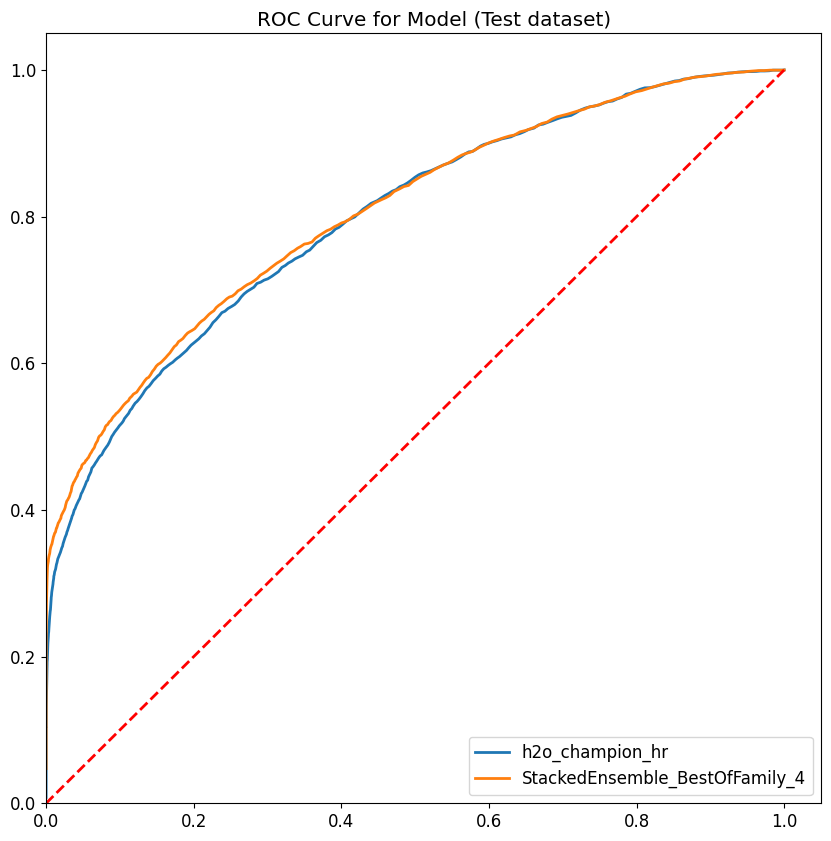

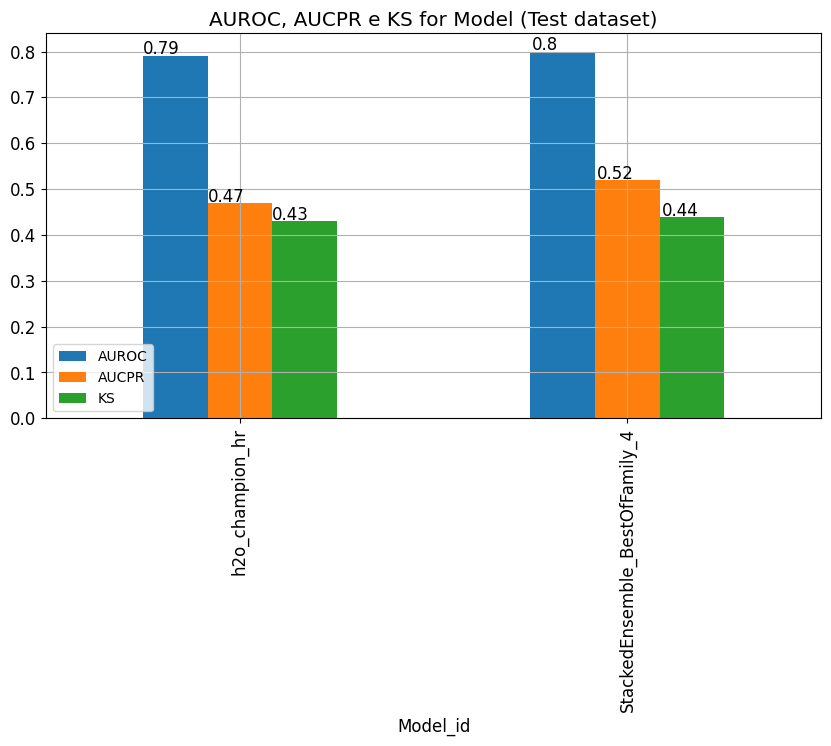

In [59]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [68]:
sort_metric_best_model='AUC'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUC


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,StackedEnsemble_BestOfFamily_4_AutoML_1_20221104_234322,0.497944,0.804326,0.526045,0.208736,0.446,0.321054
1,0,h2o_champion_hr_analytics_v1_20221104_234228,0.336147,0.796516,0.473805,0.223204,0.432,0.265798
2,0,h2o_champion_hr_analytics_v1_20221104_231942,0.315678,0.794099,0.450537,0.227780,0.431,0.182515


In [71]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)    
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    print("Warning: This model doesn't have variable importances")


BEST MODEL: StackedEnsemble_BestOfFamily_4_AutoML_1_20221104_234322

Variable importance plot is not available for this type of model (stackedensemble).

BEST MODEL: StackedEnsemble_BestOfFamily_4_AutoML_1_20221104_234322



## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [72]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [73]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'Test_Dataset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'Test_Dataset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'Test_Dataset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'Test_Dataset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'Test_Dataset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


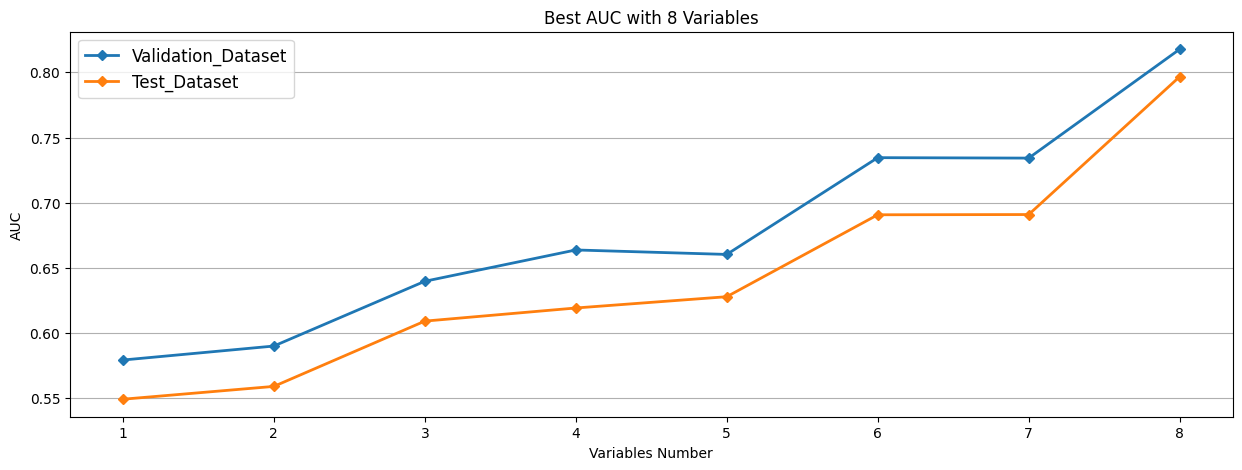

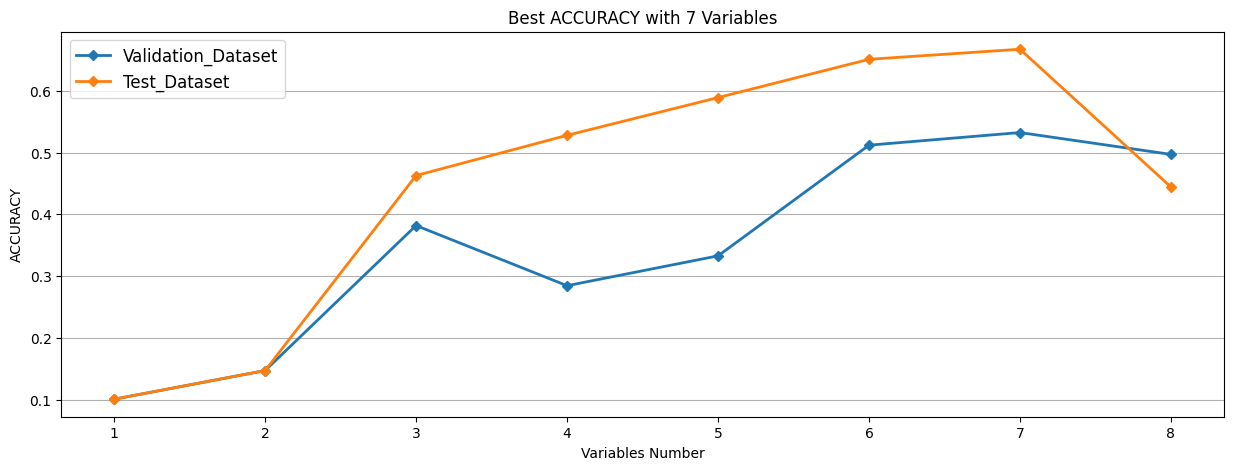

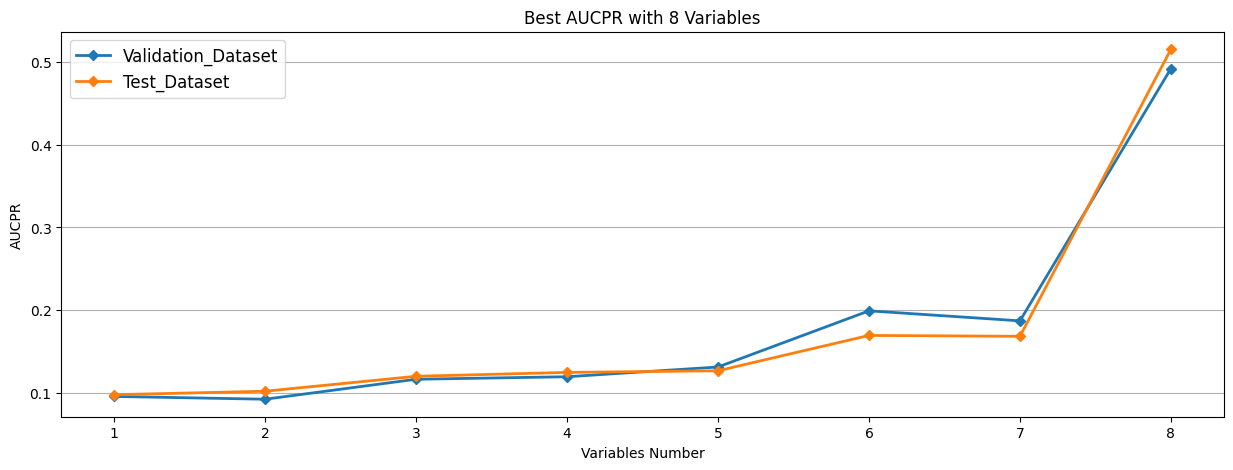

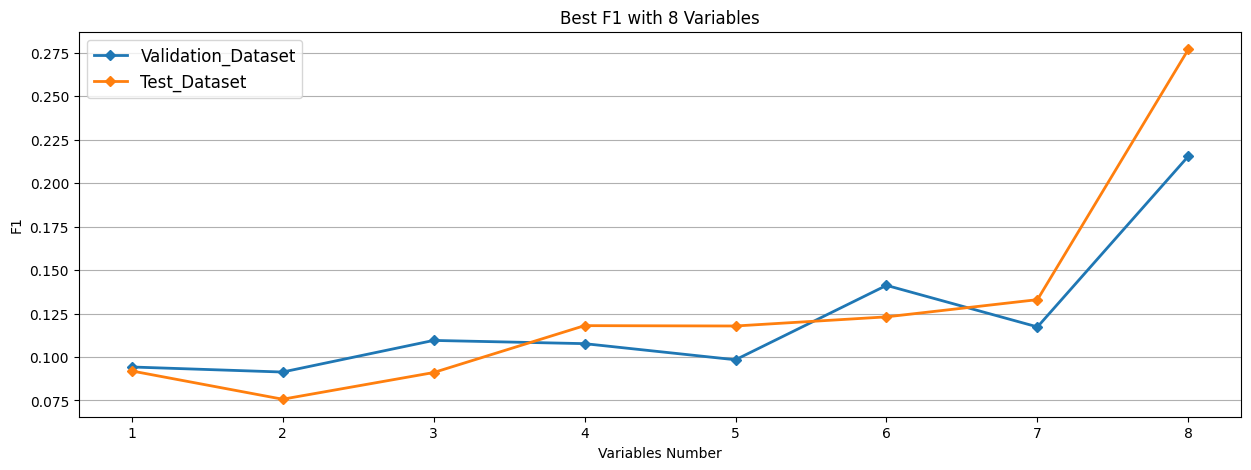

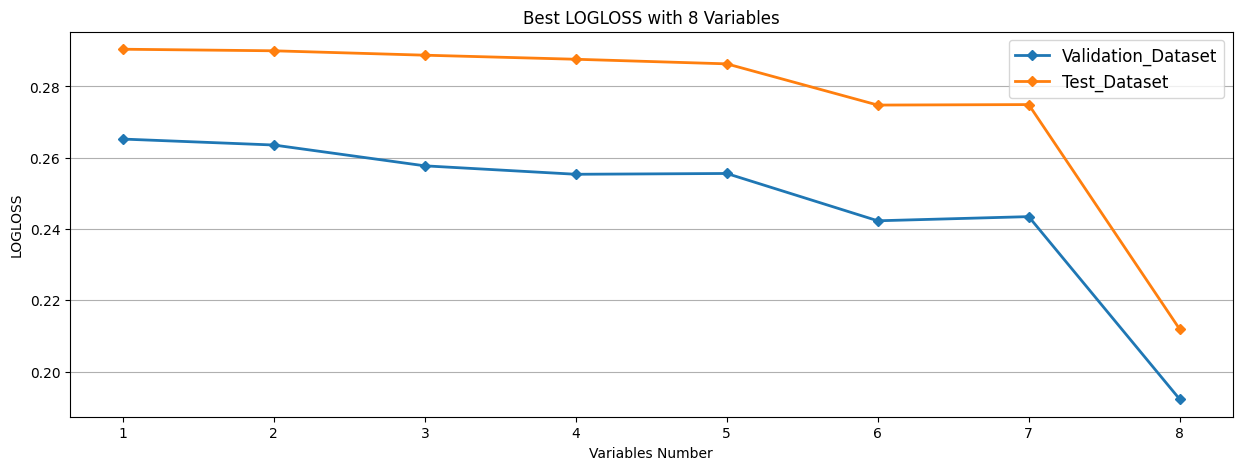

In [74]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [75]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['department', 'education', 'region', 'age', 'no_of_trainings', 'previous_year_rating', 'length_of_service', 'avg_training_score']


# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [76]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    src_path = "%s/models/candidates/%s.py" % (OutputPath, ModelId)
    dst_path = "%s/models/best/%s.py" % (OutputPath, ModelId)
    shutil.copy(src_path, dst_path)
    print('path_sagemaker_model: ' + str(dst_path))

path_model_mojo: /home/sagemaker-user/avaliacao/FIEP-Modelos-de-Aprendizado-e-Arquiteturas-Cloud/projeto_final/output_model/models/best/StackedEnsemble_BestOfFamily_4_AutoML_1_20221104_234322.zip


Detected 1 unused columns in the input data set: {}


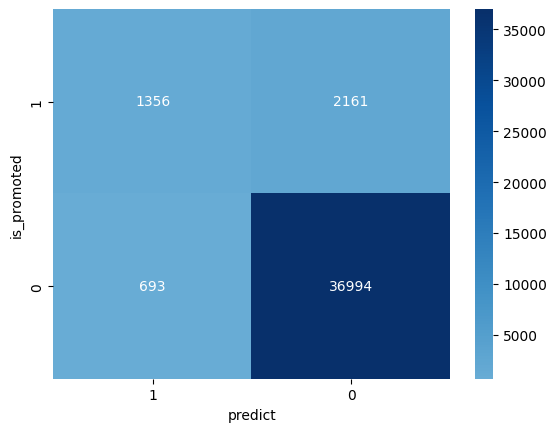

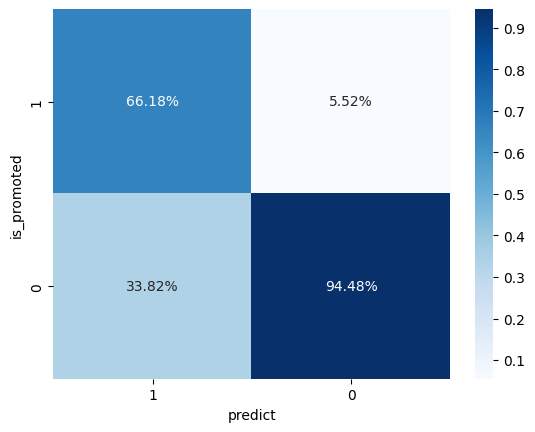

In [77]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 5.1 Cleaning Resources

In [78]:
# sm.delete_endpoint(EndpointName=ep_name)
# sm.delete_endpoint_config(EndpointConfigName=epc_name)

# 6. Save final dataset with predictions into S3 to explain the model

In [83]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [85]:
glue = my_boto3_session.client('glue', region_name="us-east-1")

try:
    glue.delete_table(
        DatabaseName='auladeploymodelos',
        Name=ModelName+'_scored'
    )
except:
    print("table does not exist")

glue.update_crawler(Name='aula-deploy-modelos',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='aula-deploy-modelos')

table does not exist


{'ResponseMetadata': {'RequestId': 'ada83e94-33ba-4862-a88a-1876a59aeba0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 05 Nov 2022 00:54:25 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'ada83e94-33ba-4862-a88a-1876a59aeba0'},
  'RetryAttempts': 0}}